In [1]:
import sys
sys.path.append("/home/ubuntu/roaddetection/")

In [2]:
#%load_ext autoreload
#%autoreload 2

from keras.layers import merge
from src.models.data import *
from src.models.model import *

from src.data.utils import get_tile_prefix
#import rasterio.plot as rioplot
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.


In [3]:
import os, shutil

original_dataset_dir = "../../data/train"
raw_images_path = "../../data/raw/images"
dirs = []

base_dir = "../../data"

train_dir = os.path.join(base_dir, "train")
dirs.append(train_dir)
validation_dir = os.path.join(base_dir, "validate")
dirs.append(validation_dir)
test_dir = os.path.join(base_dir, "test")
dirs.append(test_dir)

In [4]:
for directory in dirs:
    if not os.path.exists(directory):
       os.mkdir(directory)
    

In [4]:
from pathlib import Path


In [5]:
def should_make_tiles_from(r_analytic_name):
    is_analytic_tif = r_analytic_name.endswith(
        ('AnalyticMS.tif', 'AnalyticMS_SR.tif', 'AnalyticMS.tiff', 'AnalyticMS_SR.tiff')
    )
    return is_analytic_tif 

In [6]:
file_prefixes = [ get_tile_prefix(r_analytic.name) 
                  for r_analytic in Path(raw_images_path).iterdir()  
                    if  should_make_tiles_from(r_analytic.name)
                ]
print(file_prefixes)

['20170815_005028_0c0b_3B', '20180419_074326_0c43_3B', '20180427_020346_103a_3B', '20180504_094435_0e19_3B', '20180419_074323_0c43_3B', '20180427_020502_103c_3B', '20180427_020347_103a_3B', '20171013_232848_0c46_3B', '20180427_020501_103c_3B', '20180419_074324_0c43_3B', '20170815_005030_0c0b_3B', '20180419_074325_0c43_3B', '20180310_020202_1040_3B', '20180427_020504_103c_3B', '20180606_020625_0f1b_3B', '20180419_074324_1_0c43_3B', '20180724_094554_0e19_3B', '20170920_015736_0f28_3B', '20180427_020503_103c_3B']


In [11]:
validation_fnames = ["{0:s}_{1:04d}.tif".format(prefix, i) for i in range(1,10) for prefix in file_prefixes]
for fname in validation_fnames:
    for file_type in ["sat", "map", "sat_rgb"]:
        src = os.path.join(train_dir, file_type, fname)
        dest = os.path.join(validation_dir, file_type, fname)
        shutil.move(src, dest)

In [14]:
test_fnames = ["{0:s}_{1:04d}.tif".format(prefix, i) for i in range(40,60) for prefix in file_prefixes]
for fname in test_fnames:
    for file_type in ["sat", "map", "sat_rgb"]:
        src = os.path.join(train_dir, file_type, fname)
        dest = os.path.join(test_dir, file_type, fname)
        shutil.move(src, dest)

In [7]:
for directory in dirs:
    for file_type in ["sat", "map", "sat_rgb"]:
        target = os.path.join(directory, file_type)
        print(target, ":", len(os.listdir(target)))
    
print("Done.")

../../data/train/sat : 2715
../../data/train/map : 2715
../../data/train/sat_rgb : 2715
../../data/validate/sat : 171
../../data/validate/map : 171
../../data/validate/sat_rgb : 171
../../data/test/sat : 380
../../data/test/map : 380
../../data/test/sat_rgb : 380
Done.


In [12]:
data_gen_args = dict(
                    data_format="channels_last",
                    horizontal_flip=True
 )
train_gen = trainGenerator(2,'../../data/train','sat','map',
                        data_gen_args,save_to_dir = None,image_color_mode="rgba", target_size=(512,512))

validation_gen = trainGenerator(2,'../../data/validate','sat','map',
                        data_gen_args,save_to_dir = None,image_color_mode="rgba", target_size=(512,512))

In [13]:
model = unet(pretrained_weights="../../models/unet_membrane_analytic_27_08_14_55.hdf5")
model_checkpoint = ModelCheckpoint('../../models/unet_membrane_analytic_31_08_22_00.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=25,
                              callbacks=[model_checkpoint],
                              validation_data=validation_gen,
                              validation_steps=50
                             )

/home/ubuntu/roaddetection/src/models/model.py:60: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  model = Model(input=inputs, output=conv10)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 512, 512, 64) 2368        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 

Epoch 1/25
Found 171 images belonging to 1 classes.
Found 2715 images belonging to 1 classes.
Found 171 images belonging to 1 classes.
Found 2715 images belonging to 1 classes.
100/100 [==============================] - 192s 2s/step - loss: 0.1958 - acc: 0.9879 - auc_roc: 0.5039 - val_loss: 0.1327 - val_acc: 0.9918 - val_auc_roc: 0.4998

Epoch 00001: loss improved from inf to 0.19580, saving model to ../../models/unet_membrane_analytic_31_08_22_00.hdf5
Epoch 2/25
100/100 [==============================] - 187s 2s/step - loss: 0.1427 - acc: 0.9911 - auc_roc: 0.4999 - val_loss: 0.1332 - val_acc: 0.9917 - val_auc_roc: 0.4999

Epoch 00002: loss improved from 0.19580 to 0.14271, saving model to ../../models/unet_membrane_analytic_31_08_22_00.hdf5
Epoch 3/25
100/100 [==============================] - 186s 2s/step - loss: 0.1691 - acc: 0.9895 - auc_roc: 0.4999 - val_loss: 0.1355 - val_acc: 0.9916 - val_auc_roc: 0.4999

Epoch 00003: loss did not improve from 0.14271
Epoch 4/25
100/100 [=======

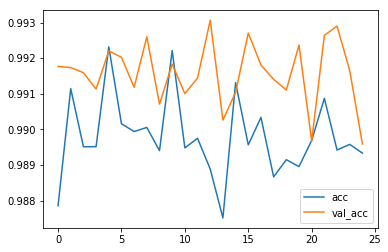

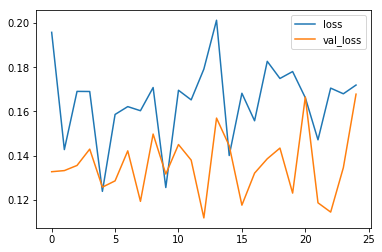

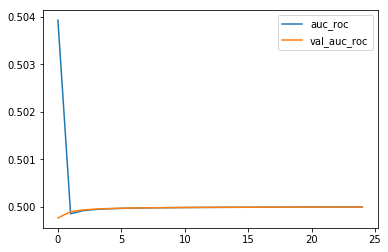

In [14]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history["acc"], label="acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(history["auc_roc"], label="auc_roc")
    plt.plot(history["val_auc_roc"], label="val_auc_roc")
    plt.legend()
    plt.show()
    plt.close()

plot_history(history.history)